In [1]:
# Data loading 

import numpy as np
import cv2
import glob
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GroupKFold, GroupShuffleSplit
import matplotlib.pyplot as plt
cmap_data = plt.cm.Paired
%matplotlib

Using matplotlib backend: TkAgg


## Train-val-test split

In [5]:
from src.data import TrainValTestSplitter, DataGenerator
from src import *
XR_HAND_PATH

'c:\\users\\valik\\documents\\lmu\\xray/data/train/XR_HAND'

In [6]:
splitter = TrainValTestSplitter()

=================Train subset=================
Size: 2846
Percentage from original data: 0.5134403752480606
Percentage of negatives: 1.0
Number of patients: 1017
=============Validation subset===============
Size: 1356
Percentage from original data: 0.24463287028684827
Percentage of negatives: 0.4837758112094395
Number of patients: 473
=================Test subset=================
Size: 1341
Percentage from original data: 0.2419267544650911
Percentage of negatives: 0.4153616703952274
Number of patients: 474


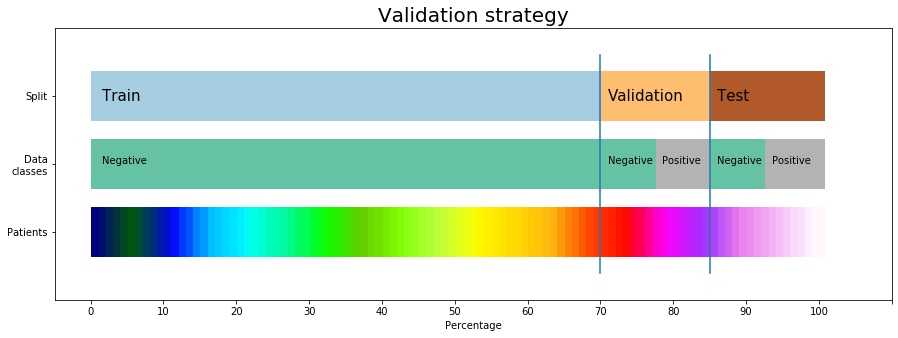

In [7]:
n_points = 100

percentiles_split = [.7, .15, .15]
train_classes = [1, .0]
val_classes = [0.5, 0.5]
test_classes = [0.5, 0.5]

split = np.hstack([[ii] * int(1000 * perc) for ii, perc in enumerate(percentiles_split)])
train_classes = np.hstack([[ii] * int(700 * perc) for ii, perc in enumerate(train_classes)])
val_classes = np.hstack([[ii] * int(150 * perc) for ii, perc in enumerate(val_classes)])
test_classes = np.hstack([[ii] * int(150 * perc) for ii, perc in enumerate(test_classes)])
groups = np.hstack([[ii] * 10 for ii in range(100)])


def visualize_groups(split, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize = (15, 5))
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_', lw=50, cmap='gist_ncar',
                  edgecolor='black')
    train_size = int(percentiles_split[0]*len(groups))
    val_size = int(percentiles_split[1]*len(groups)) 
    test_size = int(percentiles_split[2]*len(groups))

    ax.axvline(695, ymin=0.1, ymax=0.9)
    ax.axvline(845, ymin=0.1, ymax=0.9)
    
    ax.scatter(range(train_size), [2] * train_size, c=train_classes, marker='_', lw=50, cmap='Set2')
    ax.scatter(range(train_size, train_size+val_size),  [2] * val_size, c=val_classes, marker='_', lw=50, cmap='Set2')
    ax.scatter(range(train_size+val_size, train_size+val_size+test_size),  [2] * test_size, c=val_classes, marker='_', lw=50, cmap='Set2')
    ax.text(10, 2, 'Negative')
    ax.text(705, 2, 'Negative')
    ax.text(780, 2, 'Positive')
    ax.text(855, 2, 'Negative')
    ax.text(930, 2, 'Positive')
    
    
    ax.scatter(range(len(groups)),  [3.5] * len(groups), c=split, marker='_', lw=50, cmap=cmap_data)
    ax.text(10, 3.4, 'Train', fontsize=15)
    ax.text(705, 3.4, 'Validation', fontsize=15)
    ax.text(855, 3.4, 'Test', fontsize=15)
    
    
    ax.set(ylim=[-1, 5], yticks=[.5, 2.0, 3.5], xticks = range(-5, 1100, 100), xticklabels = range(0, 110, 10),
           yticklabels=['Patients', 'Data\nclasses', 'Split'], xlabel="Percentage")
    ax.set_title('Validation strategy', fontsize=20)

visualize_groups(split, groups, 'no groups')

## PyTorch model

In [20]:
from src.models import BottleneckAutoencoder
import torch.nn as nn
import torch
from src.models.pytorch_summary.torchsummary import summary

train_generator = DataGenerator(filenames=splitter.data_train.path[0:128], batch_size=32)
val_generator = DataGenerator(filenames=splitter.data_val.path[0:64], batch_size=32, 
                              true_labels=splitter.data_val.label)

In [21]:
model = BottleneckAutoencoder().cpu()
inner_loss = nn.MSELoss()
outer_loss = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [41]:
model_summary = summary(model, input_size=(train_generator.n_channels, *train_generator.dim), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             160
         MaxPool2d-2  [[-1, 16, 256, 256], [-1, 16, 256, 256]]               0
            Conv2d-3         [-1, 32, 128, 128]           8,224
         MaxPool2d-4  [[-1, 32, 64, 64], [-1, 32, 64, 64]]               0
            Conv2d-5           [-1, 64, 32, 32]          32,832
         MaxPool2d-6  [[-1, 64, 16, 16], [-1, 64, 16, 16]]               0
            Conv2d-7            [-1, 128, 8, 8]         131,200
         MaxPool2d-8  [[-1, 128, 4, 4], [-1, 128, 4, 4]]               0
            Conv2d-9            [-1, 256, 2, 2]         524,544
        MaxPool2d-10  [[-1, 256, 1, 1], [-1, 256, 1, 1]]               0
           Conv2d-11            [-1, 256, 1, 1]          65,792
  ConvTranspose2d-12            [-1, 256, 1, 1]          65,792
      MaxUnpool2d-13            [-1, 256, 2, 2] 